In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Pastel1")

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
import matplotlib as mpl
mpl.__version__

'3.4.1'

In [3]:
df_vcv = pd.read_csv("df_vcv.csv")
df_vcv.head()

,A,B,C,D,E,target
0,A0,0.0,0.0,D0,1.0,-2.963795
1,A0,0.0,0.0,D0,2.0,0.431221
2,A0,0.0,0.0,D0,3.0,0.368905
3,A0,0.0,0.0,D0,4.0,0.534808
4,A0,0.0,0.0,D1,1.0,1.779307


# data

## data split

In [4]:
X = df_vcv.iloc[:, :-1]
y = df_vcv.iloc[:, -1]

In [5]:
train_portion = 0.8

np.random.seed(42)
idx_train = np.random.choice(X.index, size=int(X.shape[0]*train_portion))
idx_test = list(set(X.index) - set(idx_train))

In [6]:
X_train = X.loc[idx_train]
X_test = X.loc[idx_test]

y_train = y.loc[idx_train]
y_test = y.loc[idx_test]

## data distribution

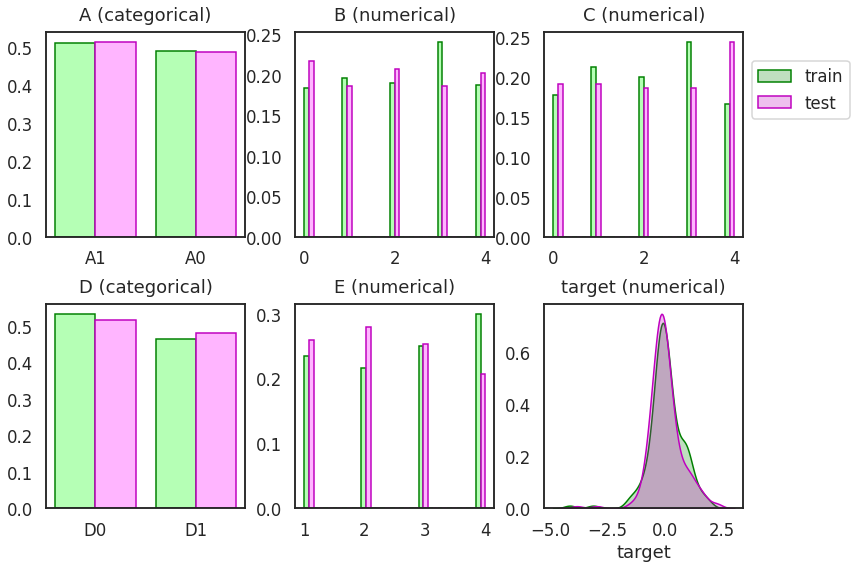

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
axs = axes.ravel()



for ax, col in zip(axs, df_vcv.columns):
    if col != "target":
        if df_vcv[col].dtype == "O": # categorical
            df_train = df_vcv.loc[idx_train, col].value_counts().reset_index()
            df_test = df_vcv.loc[idx_test, col].value_counts().reset_index()
            
            width_cat = 0.4
            ax.bar(df_train.index-width_cat/2, df_train[col]/len(idx_train), width=width_cat, ec="g", fc="#AAFFAADD")
            ax.bar(df_test.index+width_cat/2, df_test[col]/len(idx_test), width=width_cat, ec="m", fc="#FFAAFFDD")
            ax.set_xticks(list(range(df_train.shape[0])))
            ax.set_xticklabels(df_train["index"].values)
        
        else: # numerical
            bins = np.linspace(df_vcv[col].min(), df_vcv[col].max(), 20)
            bins_center = (bins[:-1] + bins[1:])/2
            bins_delta = bins[1] - bins[0]
            counts_train, bins_train = np.histogram(df_vcv.loc[idx_train, col], bins=bins)
            counts_test, bins_test = np.histogram(df_vcv.loc[idx_test, col], bins=bins)
            
            width_num = bins_delta/2
            ax.bar(bins_center-width_num/2, counts_train/len(idx_train), width=width_num, ec="g", fc="#AAFFAADD")
            ax.bar(bins_center+width_num/2, counts_test/len(idx_test), width=width_num, ec="m", fc="#FFAAFFDD")
            
    else:
        sns.kdeplot(df_vcv.loc[idx_train, col], color="g", fill=True, ax=ax, label="train")
        sns.kdeplot(df_vcv.loc[idx_test, col], color="m", fill=True, ax=ax, label="test")
        ax.set_ylabel("")
    
    if col in ["A", "D"]:
        coltype = "categorical"
    else:
        coltype = "numerical"
        
    ax.set_title(f"{col} ({coltype})", pad=12)

handles, labels = axs[5].get_legend_handles_labels()
axs[2].legend(handles, labels, loc="upper left", bbox_to_anchor=(1,0.9))    
fig.tight_layout()
fig.set_facecolor("w")
fig.savefig("6_vcv_01.png")

# ML

In [8]:
# encoder
from sklearn.preprocessing import OneHotEncoder

# machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Pipelining: test run

In [9]:
# polynomial linear regression

def linear(degree):
    
    # categorical and numerical features
    cat_features = ["A", "D"]
    cat_transformer = OneHotEncoder(sparse=False)
    
    num_features = ["B", "C", "E"]
    num_transformer = Pipeline(steps=[("scaler", StandardScaler()),
                                      ("polynomial", PolynomialFeatures(degree=degree, 
                                                                        include_bias=True))])
    
    # preprocessor
    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                                   ("cat", cat_transformer, cat_features)
                                                  ])
    
    # modeling
    model = Pipeline(steps=[("preprocessor", preprocessor), 
                            ("linear", LinearRegression())
                           ])
    
    return model

In [10]:
from sklearn import set_config
set_config(display='diagram')  

model = linear(3)
display(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['B', 'C', 'E']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['A', 'D'])])),
                ('linear', LinearRegression())])

In [11]:
set_config(display='text') 
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures(degree=3))]),
                                                  ['B', 'C', 'E']),
                                                 ('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['A', 'D'])])),
                ('linear', LinearRegression())])

## Evaluation: metrics

In [12]:
# evaluation metrics
from sklearn.metrics import mean_absolute_error as mae_
from sklearn.metrics import mean_squared_error as mse_
from sklearn.metrics import r2_score as r2_

In [13]:
def get_metrics(model, X_train, X_test, y_train, y_test):
    # train
    y_pred_train = model.predict(X_train)
    mae_train = mae_(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_(y_train, y_pred_train))
    r2_train = r2_(y_train, y_pred_train)

    # test
    y_pred_test = model.predict(X_test)
    mae_test = mae_(y_test, y_pred_test)
    rmse_test = mse_(y_test, y_pred_test, squared=False)
    r2_test = r2_(y_test, y_pred_test)

    return y_pred_train,y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test

In [14]:
y_pred_train, y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test = \
get_metrics(model, X_train, X_test, y_train, y_test)

In [15]:
print("# train dataset")
print(f"  MAE : {mae_train:.3f}")
print(f"  RMSE: {rmse_train:.3f}")
print(f"  R2  : {r2_train:.3f}")
print("\n# test dataset")
print(f"  MAE : {mae_test:.3f}")
print(f"  RMSE: {rmse_test:.3f}")
print(f"  R2  : {r2_test:.3f}")

# train dataset
  MAE : 0.394
  RMSE: 0.537
  R2  : 0.513

# test dataset
  MAE : 0.427
  RMSE: 0.568
  R2  : 0.379


## Visualization: parity plot

In [16]:
def plot_parity(true, predict, c="c", mae=None, rmse=None, r2=None, equal=False,
                title=None, xlabel="true", ylabel="predict", ax=None):
    
    # if axes not defined, create one.
    if not ax:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    # scatter plot
    ax.scatter(true, predict, c=c, s=10, alpha=0.3)
    
    # x, y limits
    min_ = min(ax.get_xbound()[0], ax.get_ybound()[0])
    max_ = max(ax.get_xbound()[1], ax.get_ybound()[1])
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    
    # x, y ticks
    lb, ub = ax.get_ybound()
    
    ticks =[x for x in ax.get_xticks() if x >= lb and x <= ub]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    
    # grids
    ax.set_aspect("equal")
    ax.grid(axis="both", c="lightgray")
    if equal:
        ax.plot([lb, ub], [lb, ub], c="k", alpha=0.3)
    
    # x, y labels and title
    ax.set_xlabel(xlabel, fontsize=16, labelpad=8)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=8)
    ax.set_title(title, fontsize=16, pad=8)
    
    # metrics
    ax.text(0.95, 0.3, f" MAE ={mae:0.3f}",
            transform=ax.transAxes, fontsize=16, ha="right")
    ax.text(0.95, 0.22, f"RMSE ={rmse:0.3f}", 
            transform=ax.transAxes, fontsize=16, ha="right")
    ax.text(0.95, 0.14, f"R2 ={r2:0.3f}", 
            transform=ax.transAxes, fontsize=16, ha="right")
    
    return ax

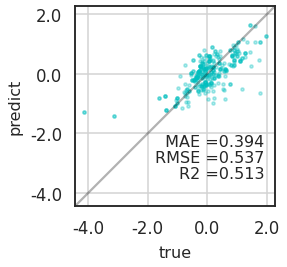

In [17]:
ax = plot_parity(y_train, y_pred_train, mae=mae_train, rmse=rmse_train, r2=r2_train, equal=True)
fig = ax.figure
fig.tight_layout()
fig.set_facecolor("w")
fig.savefig("6_vcv_02.png")

In [18]:
def plot_parities(X_train, X_test, y_train, y_test, title):
    
    # get metrics
    y_pred_train, y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test = \
    get_metrics(model, X_train, X_test, y_train, y_test)
    
    # figure prepartion
    fig, axs = plt.subplots(ncols=2, figsize=(8, 5), sharex=True, sharey=True)
    
    c_train, c_test = "g", "m"
    axs[0] = plot_parity(y_train, y_pred_train, c_train, 
                         mae_train, rmse_train, r2_train, title=f"train", ax=axs[0])
    min0, max0 = axs[0].get_xbound()
    
    axs[1] = plot_parity(y_test, y_pred_test, c_test, 
                         mae_test, rmse_test, r2_test, title=f"test", ax=axs[1])
    min1, max1 = axs[1].get_xbound()
    
    # mis setting
    axs[1].set_ylabel(None)
    min_, max_ = min(min0, min1), max(max0, max1)
    axs[1].set_xlim(min_, max_)
    axs[1].set_ylim(min_, max_)
    for ax in axs:
        ax.plot([min_, max_], [min_, max_], "k", alpha=0.3)
    
    fig.suptitle(title, fontsize=20, ha="center")
    fig.tight_layout()
    fig.set_facecolor("w")
    fig.savefig(f"{title.replace('(', '_').replace(')', '_')}.png")
    

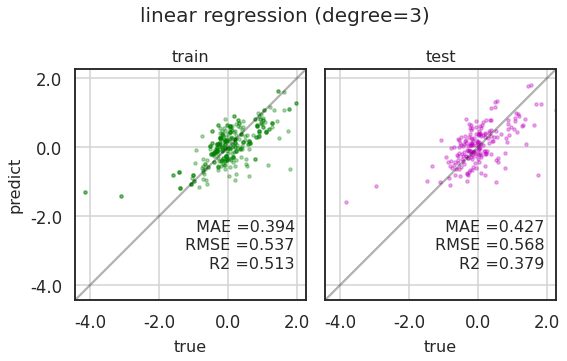

In [19]:
plot_parities(X_train, X_test, y_train, y_test, "linear regression (degree=3)")

* **Another tries: polynomial order = 3 and 1**

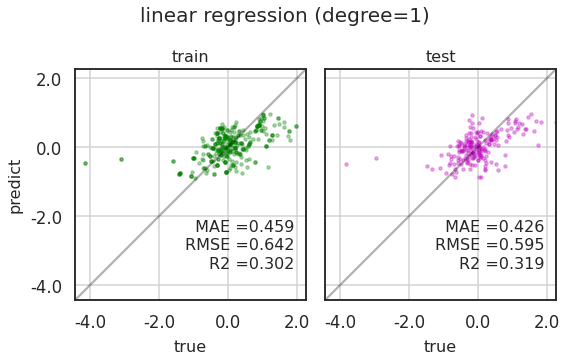

In [20]:
# degree = 1
model = linear(1)
model.fit(X_train, y_train)

y_pred_train, y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test = \
get_metrics(model, X_train, X_test, y_train, y_test)

plot_parities(X_train, X_test, y_train, y_test, "linear regression (degree=1)")

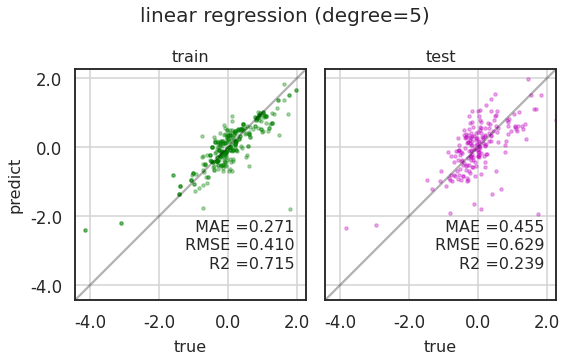

In [21]:
# degree = 5
model = linear(5)
model.fit(X_train, y_train)

y_pred_train, y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test = \
get_metrics(model, X_train, X_test, y_train, y_test)

plot_parities(X_train, X_test, y_train, y_test, "linear regression (degree=5)")

## GridSearch: Dependency on the polynomial order

In [22]:
def plot_metrics(X_train, X_test, y_train, y_test, title):
    maes_train, maes_test = [], []
    rmses_train, rmses_test = [], []
    r2s_train, r2s_test = [], []

    for degree in range(1, 6):
        # model build
        model = linear(degree)
        model.fit(X_train, y_train)

        # model evaluation
        y_pred_train, y_pred_test, mae_train, mae_test, rmse_train, rmse_test, r2_train, r2_test = \
        get_metrics(model, X_train, X_test, y_train, y_test)

        # store metrics
        maes_train.append(mae_train)
        maes_test.append(mae_test)
        rmses_train.append(rmse_train)
        rmses_test.append(rmse_test)
        r2s_train.append(r2_train)
        r2s_test.append(r2_test)

    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

    axs[0].plot(maes_train, maes_test, "ro-", lw=3)
    axs[1].plot(rmses_train, rmses_test, "go-", lw=3)
    axs[2].plot(r2s_train, r2s_test, "bo-", lw=3)


    for i in range(len(maes_train)):
        axs[0].text(maes_train[i], maes_test[i], str(i+1), ha="center", fontsize=14, 
                    bbox = {"boxstyle":"circle", "facecolor":"w", "edgecolor":"r"})
        axs[1].text(rmses_train[i], rmses_test[i], str(i+1), ha="center", fontsize=14, 
                    bbox = {"boxstyle":"circle", "facecolor":"w", "edgecolor":"g"})
        axs[2].text(r2s_train[i], r2s_test[i], str(i+1), ha="center", fontsize=14, 
                    bbox = {"boxstyle":"circle", "facecolor":"w", "edgecolor":"b"})

    for ax, metric in zip(axs, ["MAE", "RMSE", "R2"]):
        min_ = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_ = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_, max_], [min_, max_], "-k", alpha=0.3)
        ax.set_xlim(min_, max_)
        ax.set_ylim(min_, max_)
        ax.set_title(metric, pad=12)
        ax.set_xlabel("train")
        ticks = [round(x,1) for x in ax.get_xticks() if x <= ax.get_xbound()[1] and  x >= ax.get_xbound()[0]]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticks)
        ax.grid()


    axs[0].set_ylabel("test")

    fig.suptitle(f"{title}", fontsize=24)
    fig.tight_layout()
    fig.set_facecolor("w")
    fig.savefig(f"{title.replace('(','_').replace(')','_')}.png")

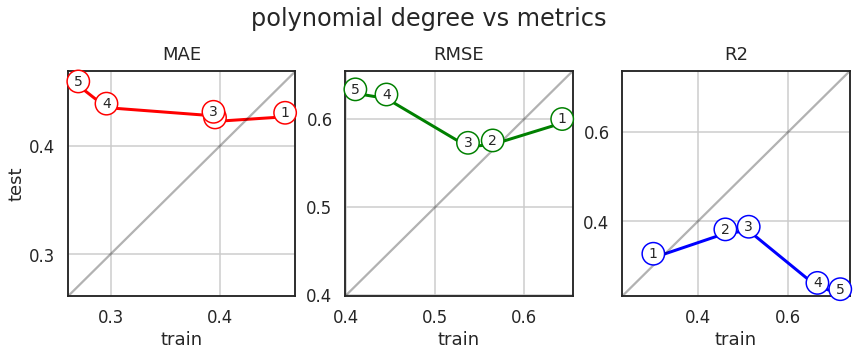

In [23]:
plot_metrics(X_train, X_test, y_train, y_test, "polynomial degree vs metrics")

* **another data split**

In [24]:
train_portion = 0.8

np.random.seed(0)
idx_train_2 = np.random.choice(X.index, size=int(X.shape[0]*train_portion))
idx_test_2 = list(set(X.index) - set(idx_train_2))

In [25]:
X_train_2 = X.loc[idx_train_2]
X_test_2 = X.loc[idx_test_2]

y_train_2 = y.loc[idx_train_2]
y_test_2 = y.loc[idx_test_2]

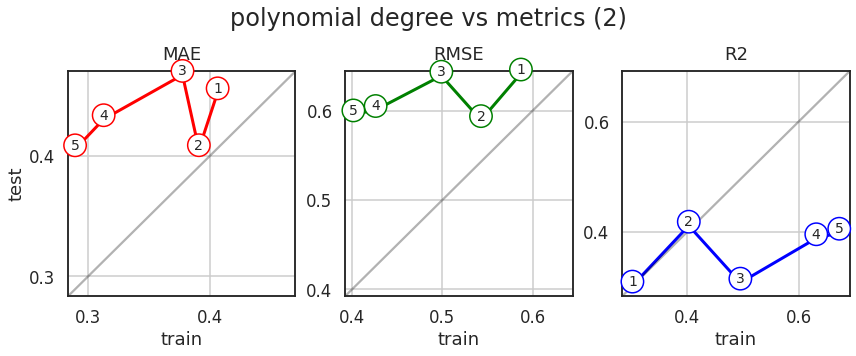

In [26]:
plot_metrics(X_train_2, X_test_2, y_train_2, y_test_2, "polynomial degree vs metrics (2)")

### cross validation

In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
def plot_cv(X_train, y_train, title):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

    for degree in range(1, 6):
        # model build
        model = linear(degree)

        # cross validation
        for scoring, ax in zip(["neg_mean_absolute_error", "neg_mean_squared_error", "r2"], axs):
            scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=10)
            if scoring.startswith("neg_"):
                scores = -scores

            cvs = ax.bar(degree, scores.mean()) 
            ax.bar_label(cvs, fmt="%.2f", fontsize=14, padding=5)
            ax.errorbar(degree, scores.mean(), yerr=scores.std(), 
                        ecolor="darkgray", capsize=5, capthick=2)

    for title_, ax in zip(["MAE", "RMSE", "R2"], axs):
        ax.set_title(title_, pad=12)
        ax.grid(axis="y", c="lightgray", ls=":")
        xticks = list(range(1, 6))
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)

    fig.suptitle(f"{title}", fontsize=24)
    fig.tight_layout()
    fig.set_facecolor("w")
    fig.savefig(f"{title.replace('(','_').replace(')','_')}.png")

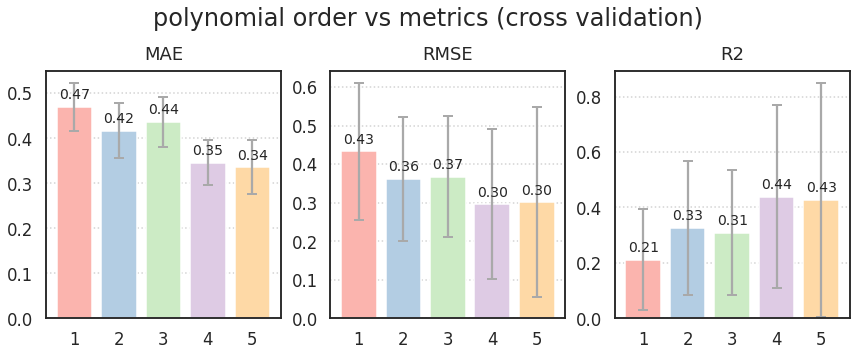

In [29]:
plot_cv(X_train, y_train, "polynomial order vs metrics (cross validation)")

* **another data split**

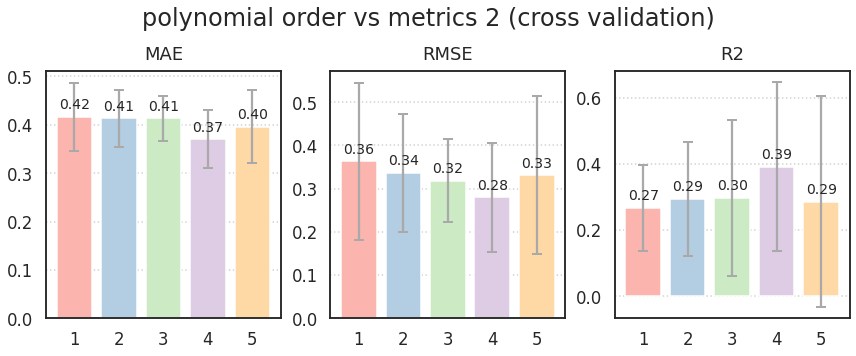

In [30]:
plot_cv(X_train_2, y_train_2, "polynomial order vs metrics 2 (cross validation)")